In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = '/Users/jeremy/data/movie_datasets/'

In [12]:
metadata = pd.read_csv(data_path + 'movies_metadata.csv', low_memory=False)
metadata.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


#### Observations

* remove 3 rows where 'adult' column seems to be broken, turns out all columns seems to be broken

In [17]:
metadata['adult'].value_counts()
metadata = metadata[metadata.adult.isin(['True','False'])]

#### Observations
* remove 2 rows where movie status was canceled
* observed also that when status is null then there were some awkward stuff like:
    * vote count = 0
    * revenue = 0 
    * some other important metafeature is null or 'default value' therefore these will be removed.

In [30]:
metadata.status.value_counts(dropna=False)
metadata[
    (metadata.status.isnull()) &
    (
        (metadata.vote_count==0) |
         (metadata.revenue == 0)
    )
]
metadata = metadata[~(metadata.status.isin(['Canceled']) | (metadata.status.isnull()))]

#### Observations

* there are a few number of movies with no vote count, these will also be removed

In [44]:
metadata = metadata[metadata.vote_count>0]

# The Metric

#### The issues
* An important metric to use for the simple recommendation system is the user ranking, but rank count show be considered, or else movies with rank 10 and 10 votes are given as much weight as movies with rank 9.6 and 1mil votes

* movies with small sample size and outling values (10s or 1s) may skew the data

#### The solution

Weighted rating

* average rating and the number of votes where movies which much higher votes count get more importance than other movies with less vote count

IMDB weighted rating:

$$\begin{equation} WR = \big(\frac{v}{v+m}R\big) + \big(\frac{m}{v+m}C\big) \end{equation}$$

where:

* **v** - number of votes for the movie
* **m** - minimum votes required 
* **R** - average rating of the movie
* **C** - mean vote over all data

`m` is a hyperparameter which needs to be optimised. let's start off with `m` being the 75th percentile, i.e. a movie is considered if it has more votes than at least 75% of the movies

### Calculate m - minimum votes required

<AxesSubplot:xlabel='vote_count', ylabel='Density'>

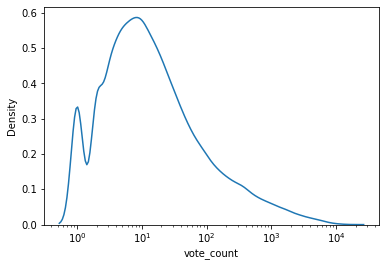

In [127]:
sns.kdeplot(metadata.vote_count,log_scale=True)

In [128]:
def count_of_values_greater_than_value(feature: pd.Series, val):
    count_ = (feature >= val).sum()
    percent = round(count_/feature.count()*100,1)
    return count_, percent

q = metadata.vote_count.quantile([0.75,0.8,0.85,0.9,0.95,1])

for idx, val in zip(q.index, q.values):
    print(f'{round(idx*100)}%', val, count_of_values_greater_than_value(metadata.vote_count, val))
                                        
 

75% 38.0 (10759, 25.3)
80% 56.0 (8561, 20.1)
85% 91.0 (6418, 15.1)
90% 179.0 (4255, 10.0)
95% 474.90000000000146 (2126, 5.0)
100% 14075.0 (1, 0.0)


In [129]:
m = metadata.vote_count.quantile(0.9)
m

179.0

## Filter metadata dataframe

In [141]:
movies = metadata.copy().loc[metadata.vote_count >= m]

### Calculate **C** - mean vote over all data

In [142]:
C = metadata.vote_average.mean()
C

6.001162270898525

## Weighted Ranking

In [146]:
def weighted_rating(df: pd.DataFrame, m=m, C=C):
    """
        compute the weighted rating of each movie
    """
    v = df.vote_count
    R = df.vote_average
    
    return round((v/(v+m))*R + (m/(v+m))*C,4)
movies.apply(weighted_rating, axis=1)

0        7.6456
1        6.8379
5        7.5527
9        6.5219
10       6.2638
          ...  
45139    5.8712
45167    6.7045
45174    6.5801
45204    6.7561
45265    6.4705
Length: 4255, dtype: float64

In [150]:
movies['score'] = movies.apply(weighted_rating, axis=1)
movies = movies.sort_values('score', ascending=False)

In [153]:
movies[['title', 'vote_count', 'vote_average', 'score']].head(50)

,title,vote_count,vote_average,score
314,The Shawshank Redemption,8358.0,8.5,8.4476
10309,Dilwale Dulhania Le Jayenge,661.0,9.1,8.4397
834,The Godfather,6024.0,8.5,8.4279
12481,The Dark Knight,12269.0,8.3,8.2669
2843,Fight Club,9678.0,8.3,8.2583
292,Pulp Fiction,8670.0,8.3,8.2535
522,Schindler's List,4436.0,8.3,8.2108
23673,Whiplash,4376.0,8.3,8.2097
5481,Spirited Away,3968.0,8.3,8.2008
2211,Life Is Beautiful,3643.0,8.3,8.1923


#### Observations

* when comparing the results with that of IMDB it looks similar however:
    * What is fight club doing in the list !!!! 🤪😡